### <center><b>АНАЛИЗ ЭФФЕКТИВНОСТИ ДВУХ ВАРИАНТОВ ПОСАДОЧНОЙ СТРАНИЦЫ</b></center>

##### <b>Задача:</b>
##### Представьте, что вы — Data Scientist в туристической фирме. Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. В результате эксперимента были собраны данные — скачайте их по [ссылке](https://lms-cdn.skillfactory.ru/assets/courseware/v1/3274d20d12cca49b6ce3d18d75ba8826/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ab_data_tourist.zip).
##### Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям — <b>конверсии покупки</b> и <b>ежедневному среднему чеку</b>.
##### Вы должны убедиться, что A/B-тестирование было проведено корректно, проверить факт стабилизации метрик и обоснованно ответить на ключевой вопрос турагентства: какой вариант посадочной страницы более предпочтителен по метрикам конверсии и ежедневного среднего чека?
##### Итак, компания предлагает следующие варианты туров:
* Таиланд — 100 000 рублей;
* Турция — 60 000 рублей;
* Мальдивы — 200 000 рублей;
* Санкт-Петербург — 10 000 рублей;
* Камчатка — 150 000 рублей.

In [1]:
# Импортируем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, shapiro
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

##### Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')

data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


##### Наша таблица представлена следующими полями:
* user_id — идентификатор пользователя, зашедшего на сайт;
* data — дата посещения сайта;
* group — группа теста (контрольная — А или тестовая — B);
* purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
* price — цена купленного тура (если покупка не состоялась, цена равна 0).

### <center>1. Анализ структуры данных и их предобработка</center>

In [3]:
# Выведем информацию о типе данных и количестве непустых значений

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


##### Пропуски в данных отсутствуют. Столбец date имеет тип object, а нам нужен datetime.

In [4]:
# Приведем столбец date к типу данных datetime

data.date = pd.to_datetime(data.date, format='%Y-%m-%d')

In [5]:
# Убедимся в одинаковой длительности проведения A/B-тестирования в каждой из групп

data.groupby('group')['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


##### Время начала и окончания теста в обоих группах совпадает, следовательно, длительность проведения теста в каждой из групп одинаковая.

In [6]:
# Проверим, есть ли пользователи, которые в процессе A/B-теста попали в обе группы

data_a = set(data[data['group']=='A']['user_id'])  # множество пользователей группы A
data_b = set(data[data['group']=='B']['user_id'])  # множество пользователей группы B

user_intersection = data_a.intersection(data_b)
len(user_intersection)

1895

##### 1895 пользователей плпали в обе группы, избавимся от них.

In [7]:
# Исключим пользователей, оказавшихся в обеих группах

data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

data.reset_index(inplace=True)

### <center>2. Первичный анализ результатов A/B-тестирования</center>

##### Рассчитаем вспомогательные показатели для контрольной и тестовой групп:
* количество посещений сайта;
* суммарное количество совершённых покупок;
* сумма всех покупок.
##### Результаты занесем в таблицу data_group

In [8]:
data_group = data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'visits',
    'purchase':'sum_purchase',
    'price':'sum_price'})

data_group

,group,visits,sum_purchase,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


#### Вывод:
* Количество посещений обоих вариантов посадочной страницы различается на 74 пользователя, что несущественно. Можно сказать, что выборка сбалансированна.

##### В каждой из групп рассчитаем ключевые показатели:
* конверсия;
* средний чек.
##### Результаты добавим в таблицу data_group

In [9]:
data_group['conversion'] = round(data_group['sum_purchase'] / data_group['visits'] * 100, 2)
data_group['mean_check'] = round(data_group['sum_price'] / data_group['sum_purchase'], 2)

data_group

,group,visits,sum_purchase,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.23
1,B,145381,17290,1533010000,11.89,88664.55


#### Вывод:
* По показателям конверсии вариант A, лучше варианта B (12.03% против 11.89%), а по среднему чеку - хуже (81076 руб. против 88665 руб.).
* По общему результату - сумме покупок - вариант B лучше варианта A (1533 млн. руб. против 1417 млн. руб.)

##### Сравним варианты A/B по покупательской способности каждого из туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
data_pivot = data[data['purchase'] == 1].pivot_table(   # оставляем в данных только строки с покупками
    values='user_id',
    index='group',
    columns='price',
    aggfunc='count'
)

data_pivot

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


##### Визуализируем полученную сводную таблицу с помощью тепловой карты.

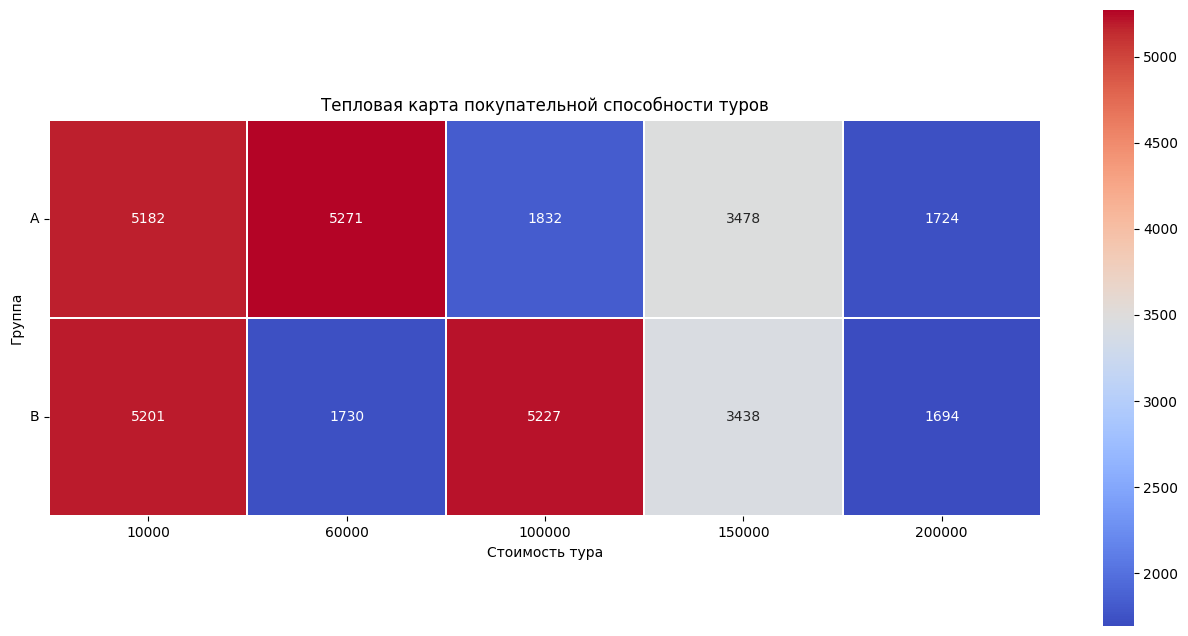

In [11]:
# Формируем полотно
fig, ax = plt.subplots(figsize=(16, 8))

# Строим график
heatmap = sns.heatmap(
    data=data_pivot, 
    annot=True, 
    fmt='d',
    cmap='coolwarm', 
    square=True,
    linewidths=0.1,
    ax=ax
)

# Поворот меток по оси ординат
plt.yticks(rotation=0)

# Подписи осей и заголовок графика
ax.set(
    xlabel='Стоимость тура',
    ylabel='Группа',
    title='Тепловая карта покупательной способности туров'
);

#### Вывод:
* Покупательская способность примерно идентична в рамках следующих направлений:
    * Санкт-Петербург (10000),
    * Камчатка (150000),
    * Мальдивы (200000);
* Покупательская способность в группе A выше в направлении Турция (60000);
* Покупательская способность в группе B выше в направлении Тайланд (100000).

### <center>3. Проанализируем данные на предмет стабилизации метрик</center>

##### Сгруппируем данные по дате и группе тестирования и построим таблицу с ежедневными данными результатов проведения A/B-тестирования. В каждой группе вычислим ежедневные показатели:
* количество посещений страницы;
* количество покупок;
* сумму покупок.

In [12]:
data_daily = data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={
    'user_id':'count_visits',
    'purchase':'count_purchase',
    'price':'sum_price'
})

data_daily.head()

,date,group,count_visits,count_purchase,sum_price
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,6596,748,62000000
3,2021-01-03,B,6619,754,65960000
4,2021-01-04,A,6566,799,64250000


##### Добавим в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и о ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок).

In [13]:
data_daily['conversion'] = round(data_daily['count_purchase'] / data_daily['count_visits'] * 100, 2)
data_daily['mean_check'] = round(data_daily['sum_price'] / data_daily['count_purchase'], 2)

data_daily.head()

,date,group,count_visits,count_purchase,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.01
1,2021-01-02,B,2861,345,29660000,12.06,85971.01
2,2021-01-03,A,6596,748,62000000,11.34,82887.70
3,2021-01-03,B,6619,754,65960000,11.39,87480.11
4,2021-01-04,A,6566,799,64250000,12.17,80413.02


##### Рассчитаем кумулятивные показатели:
* кумулятивное количество посещений страницы;
* кумулятивное количество покупок;
* кумулятивную сумму покупок.

In [14]:
data_daily['cum_count_visits'] = data_daily.groupby(['group'])['count_visits'].cumsum()
data_daily['cum_count_purchase'] = data_daily.groupby(['group'])['count_purchase'].cumsum()
data_daily['cum_sum_price'] = data_daily.groupby(['group'])['sum_price'].cumsum()

data_daily.head()

,date,group,count_visits,count_purchase,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchase,cum_sum_price
0,2021-01-02,A,2854,359,29410000,12.58,81922.01,2854,359,29410000
1,2021-01-02,B,2861,345,29660000,12.06,85971.01,2861,345,29660000
2,2021-01-03,A,6596,748,62000000,11.34,82887.70,9450,1107,91410000
3,2021-01-03,B,6619,754,65960000,11.39,87480.11,9480,1099,95620000
4,2021-01-04,A,6566,799,64250000,12.17,80413.02,16016,1906,155660000


##### На основе полученных кумулятивных показателей вычислим кумулятивную конверсию и кумулятивный средний чек.

In [15]:
data_daily['cum_conversion'] = round(data_daily['cum_count_purchase'] / data_daily['cum_count_visits'] * 100, 2)
data_daily['cum_mean_check'] = round(data_daily['cum_sum_price'] / data_daily['cum_count_purchase'], 2)

data_daily.head()

,date,group,count_visits,count_purchase,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchase,cum_sum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.01,2854,359,29410000,12.58,81922.01
1,2021-01-02,B,2861,345,29660000,12.06,85971.01,2861,345,29660000,12.06,85971.01
2,2021-01-03,A,6596,748,62000000,11.34,82887.70,9450,1107,91410000,11.71,82574.53
3,2021-01-03,B,6619,754,65960000,11.39,87480.11,9480,1099,95620000,11.59,87006.37
4,2021-01-04,A,6566,799,64250000,12.17,80413.02,16016,1906,155660000,11.90,81668.42


##### Построим кумулятивные графики конверсии и среднего чека в каждой группе по дням.

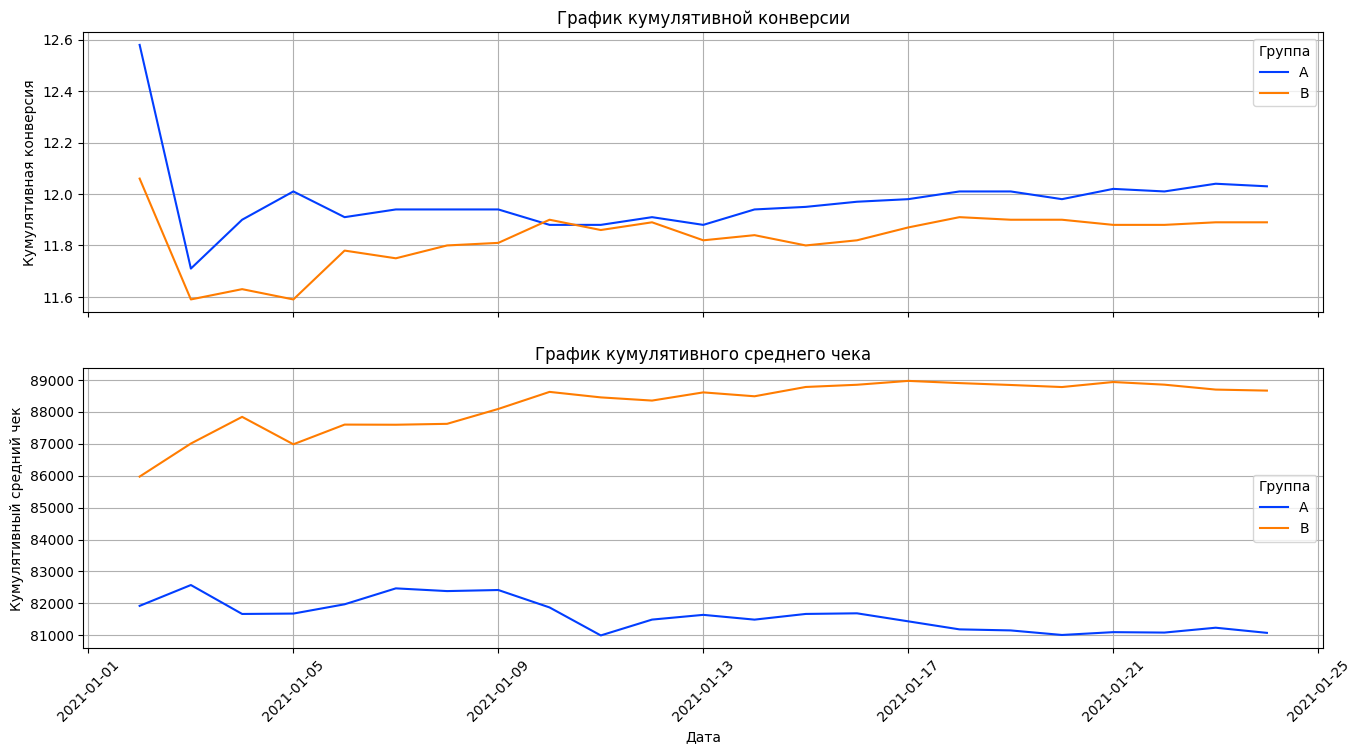

In [16]:
# Формируем полотно
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8), sharex='row')

# Строим графики
sns.lineplot(
    data=data_daily,
    x='date',
    y='cum_conversion',
    hue='group',
    ax=ax[0],
    palette='bright'
)
sns.lineplot(
    data=data_daily,
    x='date',
    y='cum_mean_check',
    hue='group',
    ax=ax[1],
    palette='bright'
)

# Подписи осей, заголовка графика и легенды
ax[0].legend(title='Группа')
ax[0].set(xticklabels=[], xlabel='', ylabel='Кумулятивная конверсия', title='График кумулятивной конверсии')
ax[0].grid(True)

ax[1].legend(title='Группа', loc='center right')
ax[1].set(xlabel='Дата', ylabel='Кумулятивный средний чек' , title='График кумулятивного среднего чека')
ax[1].grid(True);
ax[1].xaxis.set_tick_params(rotation=45);

#### Вывод:
* До 2021-01-11 кумулятивные метрики были нестабильны, но после 2021-01-13 резкие скачки прекратились (кривые графиков переходят в прямые).
* Судя по графику кумулятивной конверсии, конверсия группы B стабильно хуже конверсии группы A на всем промежутке времени.
* По графику кумулятивного среднего чека видно, что средний чек в группе A намного меньше среднего чека в группе B.
* На основании стабилизированного кумулятивного графика можно сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах. Значит, пора переходить к проведению статистических тестов.

### <center>4. Проведем статистический анализ результатов A/B-тестирования</center>

##### Определим, есть ли статистическая разница между конверсиями в группах А и B.
##### Проведем тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B.
##### Для опеределения статистической разницы применим z-тест (<i>proportions_ztest()</i>), т.к.:
* сравниваются конверсии (пропорции) по двум выборкам;
* число наблюдений достаточно велико.
##### Уровень значимости выберем $\alpha$=0.05. 

##### Но прежде проверим данные на нормальность.
##### Для этого применим критерий Шапиро — Уилка (функция <i>shapiro()</i>).
##### Проверим следующие гипотезы:
* $H_0$: Распределение выборки нормальное;
* $H_1$: Распределение выборки отлично от нормального.
##### Уровень значимости выберем $\alpha$=0.05.

In [17]:
# Проверка данных на нормальность

# Нулевая и альтернативная гипотезы
H0 = 'Распределение выборки нормальное'
H1 = 'Распределение выборки отлично от нормального'

# Уровень значимости
alpha = 0.05

# Вычисляем результат теста Шапиро — Уилка
shapiro_result = shapiro(data_daily['conversion'])

# Выводим результат на экран
print('p-value', round(shapiro_result.pvalue, 2))

# Сравниваем полученное p-value с уровнем значимости
if shapiro_result.pvalue <= alpha:
    print(f"Отвергаем нулевую гипотезу в пользу альтернативной")
    print(f"Альтернативная гипотеза: {H1}")
else:
    print(f"Принимаем нулевую гипотезу: {H0}")

p-value 0.39
Принимаем нулевую гипотезу: Распределение выборки нормальное


In [18]:
# Cгруппируем таблицу data по признаку группы и рассчитаем количество «успехов» и общее количество наблюдений для каждой группы

conversion_piv= data.groupby(by=['group'])['purchase'].agg(
    ['sum', 'count']
)

conversion_piv

,sum,count
group,,
A,17487,145307
B,17290,145381


In [19]:
# Статистический анализ A/B тестирования

# Нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'

# Уровень значимости
alpha = 0.05

# Вычисляем значение P-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=conversion_piv['sum'],  # число "успехов"
    nobs=conversion_piv['count'], # общее число наблюдений
    alternative='larger', # правосторонняя альтернативная гипотеза
)

# Выводим результат на экран
print('p-value:', round(p_value, 2))

# Сравниваем полученное p-value с уровнем значимости
if (p_value < alpha):
    print(f"Отвергаем нулевую гипотезу в пользу альтернативной")
    print(f"Альтернативная гипотеза: {H1}")
else:
    print(f"Принимаем нулевую гипотезу: {H0}")

p-value: 0.12
Принимаем нулевую гипотезу: Конверсии в группах А и B равны


#### Вывод:
##### С помощью статистических тестов удалось выяснить следующее:
* данные распределены нормально;
* конверсии в группах A и B равны.

##### Проверим гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 
##### Для этого применим критерий Шапиро — Уилка (функция <i>shapiro()</i>).
##### Проверим следующие гипотезы:
* $H_0$: Распределение выборки нормальное;
* $H_1$: Распределение выборки отлично от нормального.
##### Уровень значимости выберем $\alpha$=0.05.

In [20]:
# Фильтруем данные группы А
data_daily_a = data_daily[data_daily['group'] == 'A']

# Фильтруем данные группы B
data_daily_b = data_daily[data_daily['group'] == 'B']

In [21]:
# Проверка данных на нормальность

# Нулевая и альтернативная гипотезы
H0 = 'Распределение выборки нормальное'
H1 = 'Распределение выборки отлично от нормального'

# Уровень значимости
alpha = 0.05

# Вычисляем результат теста Шапиро — Уилка
shapiro_result_a = shapiro(data_daily_a['mean_check'])
shapiro_result_b = shapiro(data_daily_b['mean_check'])

# Выводим результат на экран
print('p-value группы A', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# Сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue > alpha:
    print(f'Для группы A: {H0}')
else:
    print(f'Для группы A: {H1}')

if shapiro_result_b.pvalue > alpha:
    print(f'Для группы B: {H0}')
else:
    print(f'Для группы B: {H1}')

p-value группы A 0.25
p-value группы B 0.09
Для группы A: Распределение выборки нормальное
Для группы B: Распределение выборки нормальное


##### Определим, есть ли статистическая разница между ежедневными средними чеками в группах А и B.
##### Проведем тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B.
##### Для опеределения статистической разницы применим t-тест (<i>ttest_ind()</i>), т.к.:
* распределение признака нормальное;
* cравниваются только две группы;
* количество объектов в выборке не больше 30.
##### Уровень значимости выберем $\alpha$=0.05.

In [22]:
# Нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'

# Уровень значимости
alpha = 0.05 

# Вычисляем результат t-теста для выборок
result = ttest_ind(
    data_daily_a['mean_check'],
    data_daily_b['mean_check'],
    alternative='less'
)

# Выводим результат на экран
print('p-value:', round(result.pvalue, 2))

# Сравниваем полученное p-value с уровнем значимости
if result.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу в пользу альтернативной")
    print(f"Альтернативная гипотеза: {H1}")
else:
    print(f"Принимаем нулевую гипотезу: {H0}")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной
Альтернативная гипотеза: Ежедневный средний чек в группе А меньше, чем в группе B


#### Вывод:
##### С помощью статистических тестов удалось выяснить следующее:
* данные распределены нормально;
* ежедневный средний чек в группе A меньше, чем в группе B.

##### Подкрепим результаты статистических тестов, построив 95 % доверительные интервалы для:
* конверсий в каждой из групп;
* разницы конверсий в группах;
* ежедневного среднего чека в каждой из групп.

In [23]:
# Функция для расчета 95 % доверительного интервала для конверсий в каждой из групп

def proportions_conf_interval(n, X_p, gamma=0.95):
  
    # Уровень значимости
    alpha = 1 - gamma

    # z-критическое
    z_crit = -stats.norm.ppf(alpha / 2)

    # Погрешность
    eps = z_crit * (X_p * (1 - X_p) / n) ** 0.5

    # Левая (нижняя) граница
    lower_bound = X_p - eps

    # Правая (верхняя) граница
    upper_bound = X_p + eps

    # Возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [24]:
# Функция для расчета 95 % доверительного интервала для разницы конверсий в группах

def diff_proportions_conf_interval(n, X_p, gamma=0.95):

    # Уровень значимости
    alpha = 1 - gamma

    # Выборочная разница конверсий групп B и A
    diff = X_p[1] - X_p[0]

    # z-критическое
    z_crit = -stats.norm.ppf(alpha / 2)

    # Погрешность
    eps = z_crit * (X_p[0] * (1 - X_p[0]) / n[0] + X_p[1] * (1 - X_p[1]) / n[1]) ** 0.5

    # Левая (нижняя) граница
    lower_bound = diff - eps

    # Правая (верхняя) граница
    upper_bound = diff + eps

    # Возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [25]:
# Функция для расчета 95 % доверительного интервала для ежедневного среднего чека в каждой из групп

def t_crit_conf_interval(n, X_mean, X_std, gamma=0.95):

    # Уровень значимости
    alpha = 1 - gamma

    # Число степеней свободы
    k = n - 1

    # t-критическое
    t_crit = -stats.t.ppf(alpha / 2, k)

    # Погрешность
    eps = t_crit * X_std / (n ** 0.5)

    # Левая (нижняя) граница
    lower_bound = X_mean - eps

    # Правая (верхняя) граница
    upper_bound = X_mean + eps

    # Возвращаем кортеж из округлённых границ интервала
    return (round(lower_bound), round(upper_bound))

In [26]:
# Фильтруем данные группы А
data_a = data[data['group'] == 'A'].copy()

# Фильтруем данные группы B
data_b = data[data['group'] == 'B'].copy()

In [27]:
# Расчёт двусторонних доверительных интервалов конверсии по группам
conf_interval_a = proportions_conf_interval(
    n = data_a['user_id'].count(),    # размер выборки
    X_p = data_a['purchase'].mean()   # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
    n = data_b['user_id'].count(),    # размер выборки
    X_p = data_b['purchase'].mean()   # выборочная пропорция
)

print(f'Доверительный интервал для конверсии группы А: {conf_interval_a}')
print(f'Доверительный интервал для конверсии группы B: {conf_interval_b}')

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [28]:
# Расчёт доверительного интервала разницы конверсии между группами

# Размеры выборок групп А и B
n = [data_a['user_id'].count(), data_b['user_id'].count()]

# Выборочная пропорция групп A и B
X_p = [data_a['purchase'].mean(), data_b['purchase'].mean()]

# Строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, X_p)

print(f'Доверительный интервал для разности конверсий: {diff_inverval}')

Доверительный интервал для разности конверсий: (-0.38, 0.09)


In [29]:
# Расчет доверительного интервала для ежедневного среднего чека в каждой из групп

# Размер выборки
n_a = data_daily_a['mean_check'].count()  
n_b = data_daily_b['mean_check'].count()

# Выборочное среднее
mean_a = data_daily_a['mean_check'].mean()
mean_b = data_daily_b['mean_check'].mean()

# Выборочное стандартное отклонение
std_a = data_daily_a['mean_check'].std()
std_b = data_daily_b['mean_check'].std()

print(f'Доверительный интервал среднего чека в группе А: {t_crit_conf_interval(n_a, mean_a, std_a)}')
print(f'Доверительный интервал среднего чека в группе B: {t_crit_conf_interval(n_b, mean_b, std_b)}')

Доверительный интервал среднего чека в группе А: (79630, 82308)
Доверительный интервал среднего чека в группе B: (87626, 89526)


#### Вывод:
* Доверительные интервалы конверсий групп А и В пересекаются, что означает достаточно большую вероятность совпадения истинных конверсий каждой из групп.
* Границы доверительного интервала разницы конверсий охватывает точку 0. Разница в конверсии с 95%-ой надёжностью может быть как положительной, так и отрицательной.
* Исходя из выше сказанного можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, т.е. они являются равнозначными по данной метрике.
* Интервал для среднего чека группы А лежит в диапазоне (79630, 82308).
* Интервал для среднего чека группы B лежит в диапазоне (87626, 89526).
* Т.е. доверительные интервалы средних чеков в группах не пересекаются, а значит с 95%-ной вероятностью можно сказать, что истинный средний чек группы В больше аналогичной метрики группы А, что подтверждает результат, ранее полученный при помощи статистического теста.

### <center>5. Сделайте общий вывод по результатам A/B-теста.</center>

##### Общий вывод по результатам A/B-теста:

* А/В-тест можно назвать завершенным, т.к. кумулятивные метрики визуально стабилизируются со временем, следовательно, удовлетворяют принципам проведения А/В тестирования.
* Группы А и В практически равнозначны по метрике конверсии.
* Группа В, однозначно, лучше группы А по метрике среднего чека.
* Дизайн страницы официального сайта компании в варианте В лучше по комплексной оценке метрик - конверсии и среднего чека.
* С точки зрения эффективности прибыльности, вариант посадочной страницы В является более эффективным по выручке компании, приходящейся на одного покупателя (средний чек).